Epoch [0/5000], Loss AB: 0.5340, Loss E: 0.5758
Epoch [100/5000], Loss AB: 0.2861, Loss E: 0.6087
Epoch [200/5000], Loss AB: 0.2322, Loss E: 0.3634
Epoch [300/5000], Loss AB: 0.2409, Loss E: 0.4641
Epoch [400/5000], Loss AB: 0.2960, Loss E: 0.3681
Epoch [500/5000], Loss AB: 0.2771, Loss E: 0.3818
Epoch [600/5000], Loss AB: 0.2520, Loss E: 0.3760
Epoch [700/5000], Loss AB: 0.2413, Loss E: 0.2965
Epoch [800/5000], Loss AB: 0.2557, Loss E: 0.2872
Epoch [900/5000], Loss AB: 0.2437, Loss E: 0.2588
Epoch [1000/5000], Loss AB: 0.2639, Loss E: 0.2584
Epoch [1100/5000], Loss AB: 0.2597, Loss E: 0.2843
Epoch [1200/5000], Loss AB: 0.2389, Loss E: 0.2551
Epoch [1300/5000], Loss AB: 0.2658, Loss E: 0.2784
Epoch [1400/5000], Loss AB: 0.2519, Loss E: 0.2479
Epoch [1500/5000], Loss AB: 0.2362, Loss E: 0.2277
Epoch [1600/5000], Loss AB: 0.2480, Loss E: 0.2842
Epoch [1700/5000], Loss AB: 0.2633, Loss E: 0.2617
Epoch [1800/5000], Loss AB: 0.2512, Loss E: 0.2481
Epoch [1900/5000], Loss AB: 0.2631, Loss E:

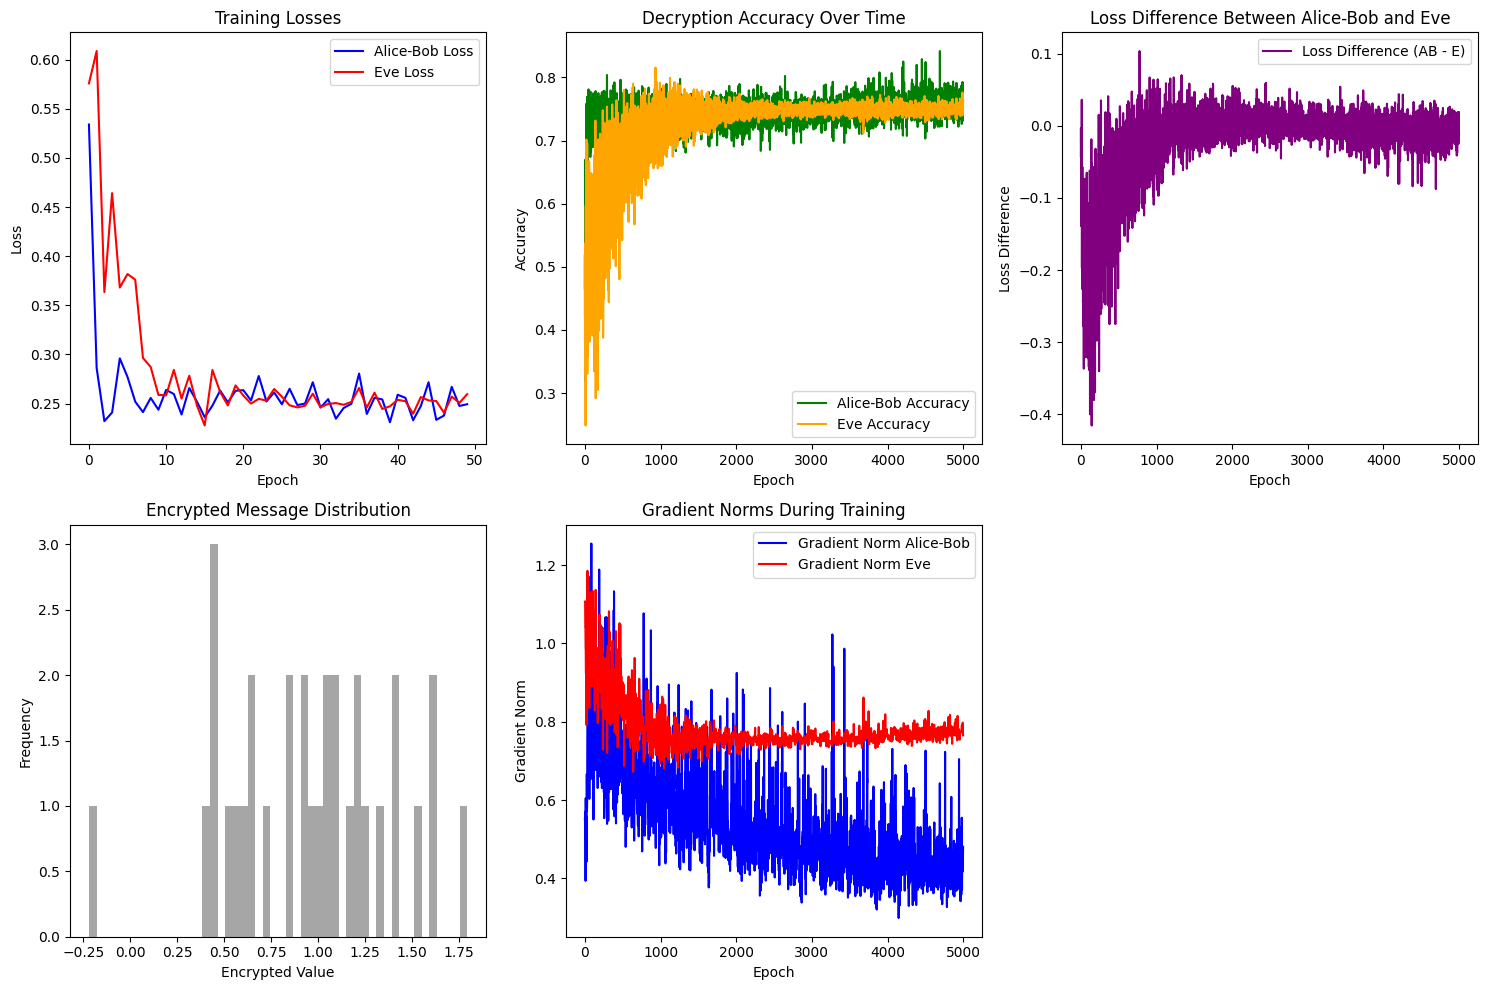

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the smart contract length (message) and key length
contract_length = 32  # Length of the smart contract message
key_length = 32  # Length of the encryption key

# Define models for Alice, Bob, and Eve
class AliceBobNet(nn.Module):
    def __init__(self):
        super(AliceBobNet, self).__init__()
        self.fc1 = nn.Linear(contract_length + key_length, 4 * (contract_length + key_length))
        self.fc2 = nn.Linear(4 * (contract_length + key_length), 2 * (contract_length + key_length))
        self.fc3 = nn.Linear(2 * (contract_length + key_length), contract_length)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class EveNet(nn.Module):
    def __init__(self):
        super(EveNet, self).__init__()
        self.fc1 = nn.Linear(contract_length, 2 * contract_length)
        self.fc2 = nn.Linear(2 * contract_length, contract_length)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models
alice_bob = AliceBobNet()
eve = EveNet()

# Loss and optimizer
criterion = nn.MSELoss()
#optimizer_ab = optim.Adam(alice_bob.parameters(), lr=0.001)
#optimizer_e = optim.Adam(eve.parameters(), lr=0.001)
optimizer_ab = optim.Adam(alice_bob.parameters(), lr=0.001)
optimizer_e = optim.Adam(eve.parameters(), lr=0.0001)


# Initialize lists to store loss values and additional data for analysis
losses_ab = []
losses_e = []
accuracies_ab = []
accuracies_e = []
loss_diffs = []
gradient_norms_ab = []
gradient_norms_e = []

# Training loop with additional data collection
epochs = 5000
for epoch in range(epochs):
    # Generate random smart contracts (binary data) and keys
    contracts = torch.randint(0, 2, (1, contract_length)).type(torch.float32)
    keys = torch.randint(0, 2, (1, key_length)).type(torch.float32)

    # Combine contract and key for Alice
    alice_input = torch.cat((contracts, keys), dim=1)

    # Encrypt contract
    encrypted_contract = alice_bob(alice_input).detach()  # Detach to prevent gradients flowing to Alice during Eve's training

    # Decrypt contract (Bob uses the same model as Alice)
    bob_input = torch.cat((encrypted_contract, keys), dim=1)
    decrypted_contract = alice_bob(bob_input)

    # Eve's attempt to decrypt, without detaching encrypted_contract from the graph
    # Add noise to the encrypted contract before passing to Eve
    # Eve's attempt to decrypt, with noise added to the encrypted contract
    noise = torch.randn_like(encrypted_contract) * 0.01  # Adding small Gaussian noise
    eve_decrypted_contract = eve(encrypted_contract + noise)


    # Calculate loss for Alice and Bob
    loss_ab = criterion(decrypted_contract, contracts)

    # Backprop for Alice and Bob more frequently (every epoch)
    if epoch % 2 == 0:  # Adjust frequency as needed
        optimizer_ab.zero_grad()
        loss_ab.backward()
        optimizer_ab.step()

    # Calculate loss for Eve
    loss_e = criterion(eve_decrypted_contract, contracts)

    # Backprop for Eve less frequently (every 4th epoch)
    if epoch % 4 == 0:  # Adjust frequency as needed
        optimizer_e.zero_grad()
        loss_e.backward()
        optimizer_e.step()

    # Calculate accuracy as 1 - normalized MSE
    accuracy_ab = 1 - nn.functional.mse_loss(decrypted_contract, contracts, reduction='mean').item()
    accuracy_e = 1 - nn.functional.mse_loss(eve_decrypted_contract, contracts, reduction='mean').item()

    # Store the metrics
    accuracies_ab.append(accuracy_ab)
    accuracies_e.append(accuracy_e)
    loss_diffs.append(loss_ab.item() - loss_e.item())
    gradient_norms_ab.append(torch.norm(torch.stack([torch.norm(p.grad) for p in alice_bob.parameters() if p.grad is not None])))
    gradient_norms_e.append(torch.norm(torch.stack([torch.norm(p.grad) for p in eve.parameters() if p.grad is not None])))

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss AB: {loss_ab.item():.4f}, Loss E: {loss_e.item():.4f}')
        losses_ab.append(loss_ab.item())
        losses_e.append(loss_e.item())


# Encrypt and decrypt a sample contract
sample_contract = torch.randint(0, 2, (1, contract_length)).type(torch.float32)
sample_key = torch.randint(0, 2, (1, key_length)).type(torch.float32)

alice_input = torch.cat((sample_contract, sample_key), dim=1)
encrypted_contract = alice_bob(alice_input)
bob_input = torch.cat((encrypted_contract, sample_key), dim=1)
decrypted_contract = alice_bob(bob_input)

print(f'Original Contract: {sample_contract}')
print(f'Decrypted Contract: {decrypted_contract}')

# Plotting the loss values and additional graphs
plt.figure(figsize=(15, 10))

# Loss for Alice and Bob
plt.subplot(2, 3, 1)
plt.plot(losses_ab, label='Alice-Bob Loss', color='blue')
plt.plot(losses_e, label='Eve Loss', color='red')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy for Alice-Bob and Eve
plt.subplot(2, 3, 2)
plt.plot(accuracies_ab, label='Alice-Bob Accuracy', color='green')
plt.plot(accuracies_e, label='Eve Accuracy', color='orange')
plt.title('Decryption Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Difference between Alice-Bob and Eve
plt.subplot(2, 3, 3)
plt.plot(loss_diffs, label='Loss Difference (AB - E)', color='purple')
plt.title('Loss Difference Between Alice-Bob and Eve')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.legend()

# Encrypted Message Distribution
plt.subplot(2, 3, 4)
plt.hist(encrypted_contract.detach().numpy().flatten(), bins=50, color='grey', alpha=0.7)
plt.title('Encrypted Message Distribution')
plt.xlabel('Encrypted Value')
plt.ylabel('Frequency')

# Gradient Norms for Alice-Bob and Eve
plt.subplot(2, 3, 5)
plt.plot(gradient_norms_ab, label='Gradient Norm Alice-Bob', color='blue')
plt.plot(gradient_norms_e, label='Gradient Norm Eve', color='red')
plt.title('Gradient Norms During Training')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


Epoch [0/5000], Loss AB: 0.5656, Loss E: 0.7459, KAR: 0.4375, DFR: 0.6250
Epoch [100/5000], Loss AB: 0.2350, Loss E: 0.4686, KAR: 0.5625, DFR: 0.4062
Epoch [200/5000], Loss AB: 0.3457, Loss E: 0.5773, KAR: 0.4062, DFR: 0.5000
Epoch [300/5000], Loss AB: 0.2503, Loss E: 0.3959, KAR: 0.5000, DFR: 0.4062
Epoch [400/5000], Loss AB: 0.2533, Loss E: 0.3241, KAR: 0.5625, DFR: 0.4375
Epoch [500/5000], Loss AB: 0.2536, Loss E: 0.4036, KAR: 0.6250, DFR: 0.5312
Epoch [600/5000], Loss AB: 0.2675, Loss E: 0.3623, KAR: 0.4688, DFR: 0.5312
Epoch [700/5000], Loss AB: 0.2593, Loss E: 0.3686, KAR: 0.4688, DFR: 0.5000
Epoch [800/5000], Loss AB: 0.2707, Loss E: 0.3322, KAR: 0.4688, DFR: 0.5312
Epoch [900/5000], Loss AB: 0.2641, Loss E: 0.3908, KAR: 0.5625, DFR: 0.6250
Epoch [1000/5000], Loss AB: 0.2822, Loss E: 0.3135, KAR: 0.5312, DFR: 0.5312
Epoch [1100/5000], Loss AB: 0.2418, Loss E: 0.3210, KAR: 0.5625, DFR: 0.5312
Epoch [1200/5000], Loss AB: 0.2636, Loss E: 0.2376, KAR: 0.4375, DFR: 0.3438
Epoch [1300

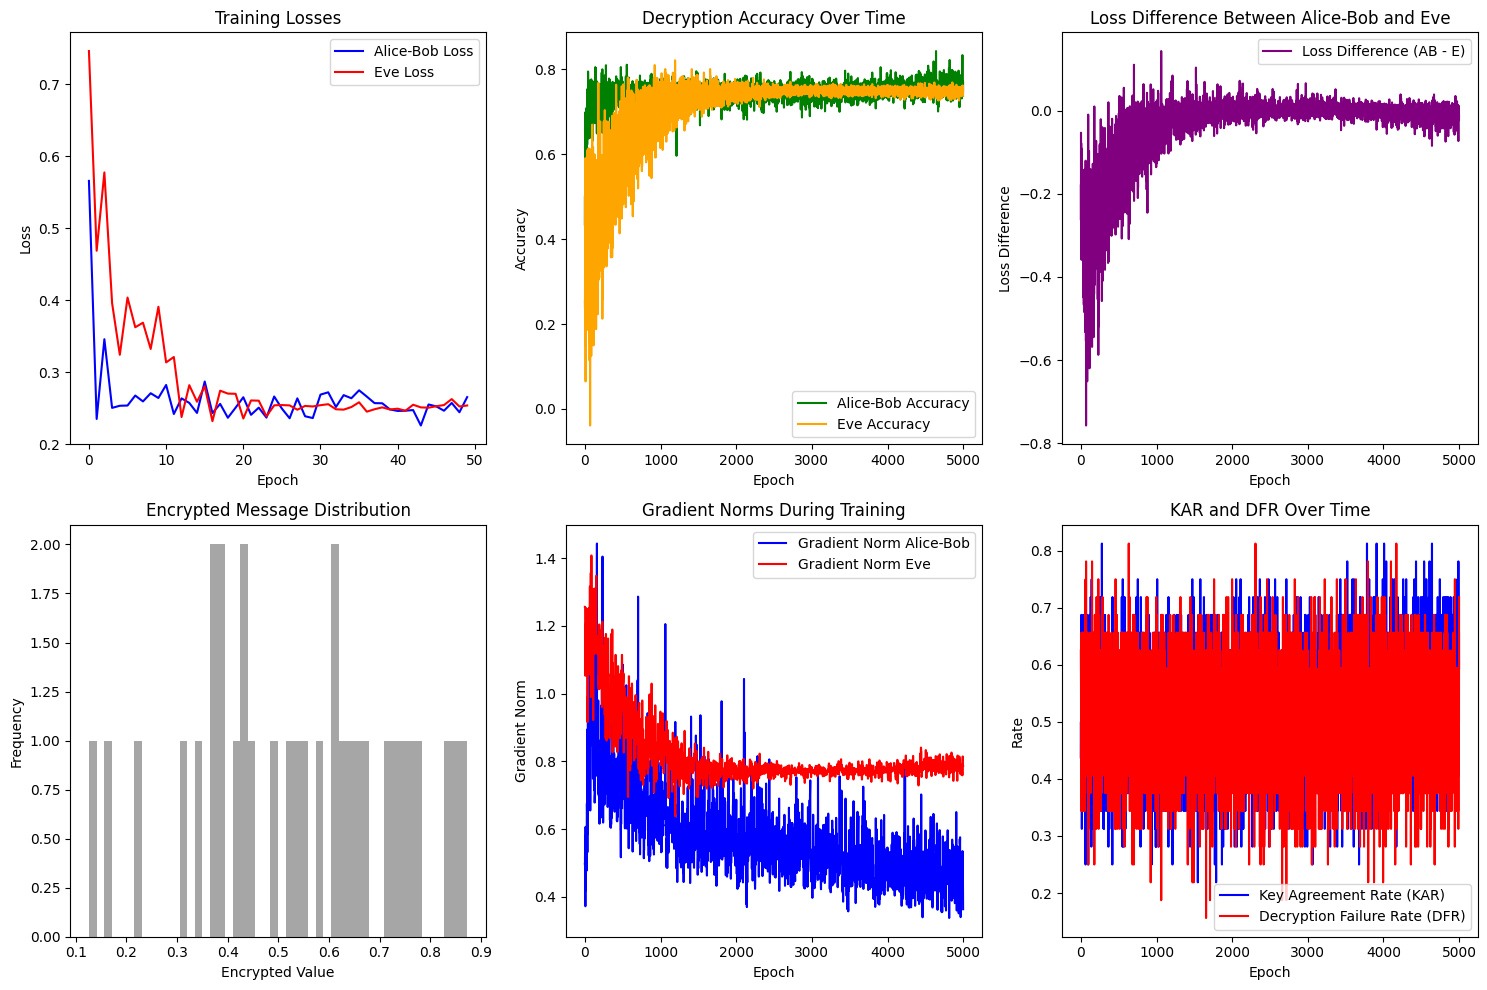

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the smart contract length (message) and key length
contract_length = 32  # Length of the smart contract message
key_length = 32  # Length of the encryption key

# Define models for Alice, Bob, and Eve
class AliceBobNet(nn.Module):
    def __init__(self):
        super(AliceBobNet, self).__init__()
        self.fc1 = nn.Linear(contract_length + key_length, 4 * (contract_length + key_length))
        self.fc2 = nn.Linear(4 * (contract_length + key_length), 2 * (contract_length + key_length))
        self.fc3 = nn.Linear(2 * (contract_length + key_length), contract_length)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class EveNet(nn.Module):
    def __init__(self):
        super(EveNet, self).__init__()
        self.fc1 = nn.Linear(contract_length, 2 * contract_length)
        self.fc2 = nn.Linear(2 * contract_length, contract_length)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models
alice_bob = AliceBobNet()
eve = EveNet()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer_ab = optim.Adam(alice_bob.parameters(), lr=0.001)
optimizer_e = optim.Adam(eve.parameters(), lr=0.0001)

# Initialize lists to store loss values and additional data for analysis
losses_ab = []
losses_e = []
accuracies_ab = []
accuracies_e = []
loss_diffs = []
gradient_norms_ab = []
gradient_norms_e = []
key_agreement_rates = []
decryption_failure_rates = []

# Training loop with additional data collection
epochs = 5000
for epoch in range(epochs):
    # Generate random smart contracts (binary data) and keys
    contracts = torch.randint(0, 2, (1, contract_length)).type(torch.float32)
    keys = torch.randint(0, 2, (1, key_length)).type(torch.float32)

    # Combine contract and key for Alice
    alice_input = torch.cat((contracts, keys), dim=1)

    # Encrypt contract
    encrypted_contract = alice_bob(alice_input).detach()  # Detach to prevent gradients flowing to Alice during Eve's training

    # Decrypt contract (Bob uses the same model as Alice)
    bob_input = torch.cat((encrypted_contract, keys), dim=1)
    decrypted_contract = alice_bob(bob_input)

    # Eve's attempt to decrypt, with noise added to the encrypted contract
    noise = torch.randn_like(encrypted_contract) * 0.01  # Adding small Gaussian noise
    eve_decrypted_contract = eve(encrypted_contract + noise)

    # Calculate loss for Alice and Bob
    loss_ab = criterion(decrypted_contract, contracts)

    # Backprop for Alice and Bob
    if epoch % 2 == 0:  # Adjust frequency as needed
        optimizer_ab.zero_grad()
        loss_ab.backward()
        optimizer_ab.step()

    # Calculate loss for Eve
    loss_e = criterion(eve_decrypted_contract, contracts)

    # Backprop for Eve
    if epoch % 4 == 0:  # Adjust frequency as needed
        optimizer_e.zero_grad()
        loss_e.backward()
        optimizer_e.step()

    # Calculate accuracy as 1 - normalized MSE
    accuracy_ab = 1 - nn.functional.mse_loss(decrypted_contract, contracts, reduction='mean').item()
    accuracy_e = 1 - nn.functional.mse_loss(eve_decrypted_contract, contracts, reduction='mean').item()

    # Calculate Key Agreement Rate (KAR)
    kar = (decrypted_contract.round() == contracts).float().mean().item()
    key_agreement_rates.append(kar)

    # Calculate Eve's Decryption Failure Rate (DFR)
    dfr = 1 - (eve_decrypted_contract.round() == contracts).float().mean().item()
    decryption_failure_rates.append(dfr)

    # Store the metrics
    accuracies_ab.append(accuracy_ab)
    accuracies_e.append(accuracy_e)
    loss_diffs.append(loss_ab.item() - loss_e.item())
    gradient_norms_ab.append(torch.norm(torch.stack([torch.norm(p.grad) for p in alice_bob.parameters() if p.grad is not None])))
    gradient_norms_e.append(torch.norm(torch.stack([torch.norm(p.grad) for p in eve.parameters() if p.grad is not None])))

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss AB: {loss_ab.item():.4f}, Loss E: {loss_e.item():.4f}, KAR: {kar:.4f}, DFR: {dfr:.4f}')
        losses_ab.append(loss_ab.item())
        losses_e.append(loss_e.item())

# Encrypt and decrypt a sample contract
sample_contract = torch.randint(0, 2, (1, contract_length)).type(torch.float32)
sample_key = torch.randint(0, 2, (1, key_length)).type(torch.float32)

alice_input = torch.cat((sample_contract, sample_key), dim=1)
encrypted_contract = alice_bob(alice_input)
bob_input = torch.cat((encrypted_contract, sample_key), dim=1)
decrypted_contract = alice_bob(bob_input)

# Calculate KAR and DFR for the sample
sample_kar = (decrypted_contract.round() == sample_contract).float().mean().item()
sample_dfr = 1 - (eve(encrypted_contract).round() == sample_contract).float().mean().item()

print(f'Original Contract: {sample_contract}')
print(f'Decrypted Contract: {decrypted_contract}')
print(f'Sample KAR: {sample_kar:.4f}')
print(f'Sample DFR: {sample_dfr:.4f}')

# Plotting the loss values and additional graphs
plt.figure(figsize=(15, 10))

# Loss for Alice and Bob
plt.subplot(2, 3, 1)
plt.plot(losses_ab, label='Alice-Bob Loss', color='blue')
plt.plot(losses_e, label='Eve Loss', color='red')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy for Alice-Bob and Eve
plt.subplot(2, 3, 2)
plt.plot(accuracies_ab, label='Alice-Bob Accuracy', color='green')
plt.plot(accuracies_e, label='Eve Accuracy', color='orange')
plt.title('Decryption Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Difference between Alice-Bob and Eve
plt.subplot(2, 3, 3)
plt.plot(loss_diffs, label='Loss Difference (AB - E)', color='purple')
plt.title('Loss Difference Between Alice-Bob and Eve')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.legend()

# Encrypted Message Distribution
plt.subplot(2, 3, 4)
plt.hist(encrypted_contract.detach().numpy().flatten(), bins=50, color='grey', alpha=0.7)
plt.title('Encrypted Message Distribution')
plt.xlabel('Encrypted Value')
plt.ylabel('Frequency')

# Gradient Norms for Alice-Bob and Eve
plt.subplot(2, 3, 5)
plt.plot(gradient_norms_ab, label='Gradient Norm Alice-Bob', color='blue')
plt.plot(gradient_norms_e, label='Gradient Norm Eve', color='red')
plt.title('Gradient Norms During Training')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()

# Key Agreement Rate (KAR) and Decryption Failure Rate (DFR)
plt.subplot(2, 3, 6)
plt.plot(key_agreement_rates, label='Key Agreement Rate (KAR)', color='blue')
plt.plot(decryption_failure_rates, label='Decryption Failure Rate (DFR)', color='red')
plt.title('KAR and DFR Over Time')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.show()
